Model 3 - Custom ResNet Summary

- **Architecture**: Variable-depth ResNet (depth=20) with multiple residual blocks across 3 stages

- **Filter Progression**: 16→32→64 channels (narrower but deeper network)

- **Pooling**: Uses strided convolutions for downsampling and GlobalAveragePooling at the end

- **Regularization**: Dropout (0.2) within residual blocks and adaptive learning rate reduction

- **Data Augmentation**: More extensive with flips, rotations, zooms, and translations

- **Optimization**: AdamW with ReduceLROnPlateau for adaptive learning rate adjustment

- **Parameters**: More layers but fewer filters per layer compared to the ResNet9. Batch size of 128

This implementation follows the original ResNet design philosophy with a focus on depth over width, and includes more advanced regularization techniques.

Notable Results (Validation Set):

*   Average Loss: 0.432
*   Top 1 Error-rate: 0.131
*   Top 5 Error-rate: 0.004



In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize images using mean and std
mean = np.mean(x_train, axis=(0, 1, 2))
std = np.std(x_train, axis=(0, 1, 2))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

def residual_block(x, filters, kernel_size=3, stride=1, drop_rate=0.0, conv_shortcut=True):
    shortcut = x

    # 1x1 convolution for shortcut if needed
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same")(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # First convolutional block
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional block
    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Adding shortcut to the output and applying ReLU
    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)

    # Dropout layer if specified
    if drop_rate > 0:
        x = layers.Dropout(drop_rate)(x)

    return x

def build_custom_resnet(depth=20, num_classes=10, drop_rate=0.2):
    assert (depth - 2) % 6 == 0, "Depth should be 6n+2"
    n = (depth - 2) // 6  # Number of residual blocks per layer

    inputs = layers.Input(shape=(32, 32, 3))

    # Initial Conv Layer
    x = layers.Conv2D(16, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Layer 1
    for _ in range(n):
        x = residual_block(x, 16, drop_rate=drop_rate)

    # Layer 2
    x = residual_block(x, 32, stride=2, drop_rate=drop_rate)
    for _ in range(n - 1):
        x = residual_block(x, 32, drop_rate=drop_rate)

    # Layer 3
    x = residual_block(x, 64, stride=2, drop_rate=drop_rate)
    for _ in range(n - 1):
        x = residual_block(x, 64, drop_rate=drop_rate)

    # Global Average Pooling and Final Dense Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation="softmax")(x)

    return models.Model(inputs, x)

# Create data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Build and compile model
model = build_custom_resnet(depth=20, num_classes=10, drop_rate=0.2)
optimizer = tf.keras.optimizers.AdamW(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_accuracy')
    ]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Training
history = model.fit(x_train,
    y_train,
    batch_size=128,
    epochs=100,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
test_loss, test_acc, test_top5_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\nFinal Test Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"Top-1 Error Rate: {(1-test_acc):.4f} (Accuracy: {test_acc:.4f})")
print(f"Top-5 Error Rate: {(1-test_top5_acc):.4f} (Accuracy: {test_top5_acc:.4f})")


Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 64s 77ms/step - accuracy: 0.3040 - loss: 1.8584 - top5_accuracy: 0.8038 - val_accuracy: 0.4061 - val_loss: 1.7078 - val_top5_accuracy: 0.9102 - learning_rate: 0.0010
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.5350 - loss: 1.2775 - top5_accuracy: 0.9432 - val_accuracy: 0.5250 - val_loss: 1.4177 - val_top5_accuracy: 0.9406 - learning_rate: 0.0010
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.6153 - loss: 1.0652 - top5_accuracy: 0.9622 - val_accuracy: 0.5866 - val_loss: 1.2031 - val_top5_accuracy: 0.9442 - learning_rate: 0.0010
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6591 - loss: 0.9588 - top5_accuracy: 0.9692 - val_accuracy: 0.6293 - val_loss: 1.0600 - val_top5_accuracy: 0.9702 - learning_rate: 0.0010
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.6943 - loss: 0.8637 - top5_accuracy: 0.9778 - val_accuracy: 0.6520 - val_loss: 0.9980 - val_top5_accura

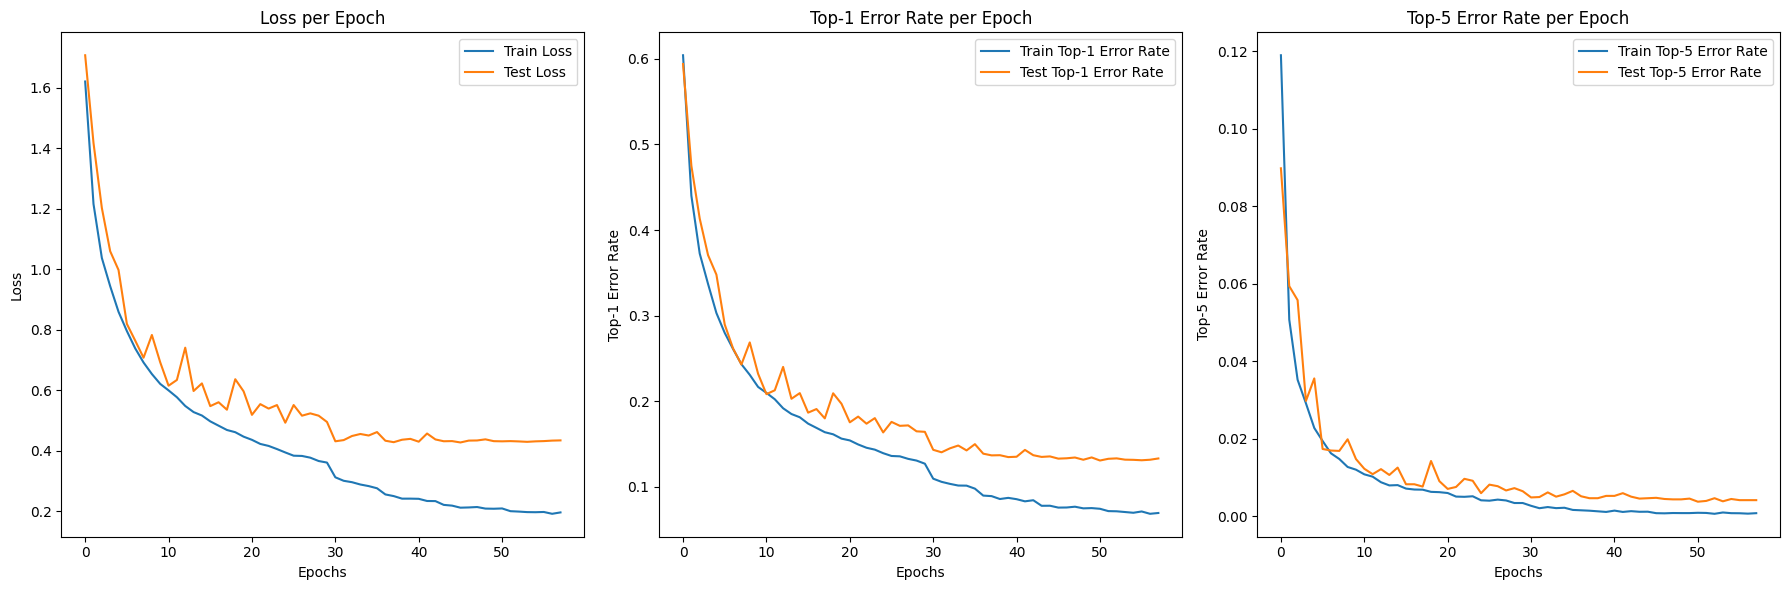

In [3]:
import matplotlib.pyplot as plt

# Extract values from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_top5_accuracy = history.history['top5_accuracy']
val_top5_accuracy = history.history['val_top5_accuracy']

# Calculate top-1 error rate
train_top1_error = 1 - np.array(train_accuracy)
val_top1_error = 1 - np.array(val_accuracy)

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Loss
axes[0].plot(train_loss, label='Train Loss')
axes[0].plot(val_loss, label='Test Loss')
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot 2: Top-1 Error Rate
axes[1].plot(train_top1_error, label='Train Top-1 Error Rate')
axes[1].plot(val_top1_error, label='Test Top-1 Error Rate')
axes[1].set_title('Top-1 Error Rate per Epoch')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Top-1 Error Rate')
axes[1].legend()

# Plot 3: Top-5 Error Rate
train_top5_error = 1 - np.array(train_top5_accuracy)
val_top5_error = 1 - np.array(val_top5_accuracy)

axes[2].plot(train_top5_error, label='Train Top-5 Error Rate')
axes[2].plot(val_top5_error, label='Test Top-5 Error Rate')
axes[2].set_title('Top-5 Error Rate per Epoch')
axes[2].set_xlabel('Epochs')
axes[2].set_ylabel('Top-5 Error Rate')
axes[2].legend()

# Show plots
plt.tight_layout()
plt.show()


Performance Considerations

Parameter Efficiency:

- ResNet9: Uses more filters (up to 512) and potentially has more parameters
- Custom ResNet: Likely more parameter-efficient with its 16→32→64 filter pattern


Computational Cost:

- ResNet9: Heavier computation with larger filters
- Custom ResNet: More layers but smaller filter sizes


Expected Behavior:

- ResNet9: Potentially higher capacity but may overfit without proper regularization
- Custom ResNet: Better regularized (dropout + LR schedule), likely less prone to overfitting


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


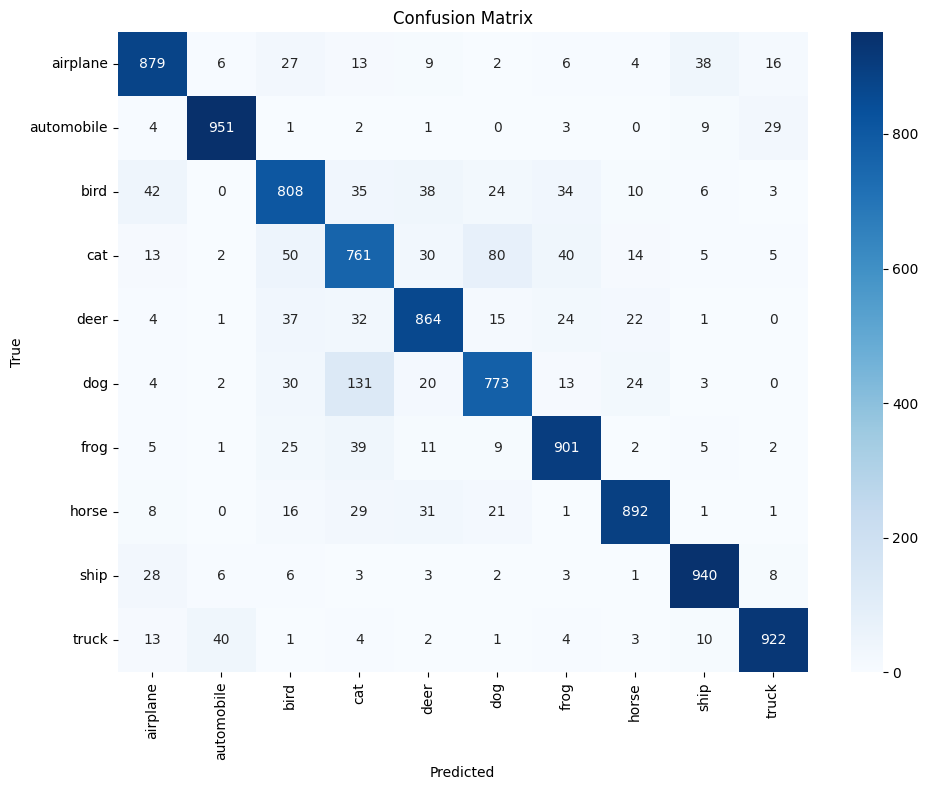

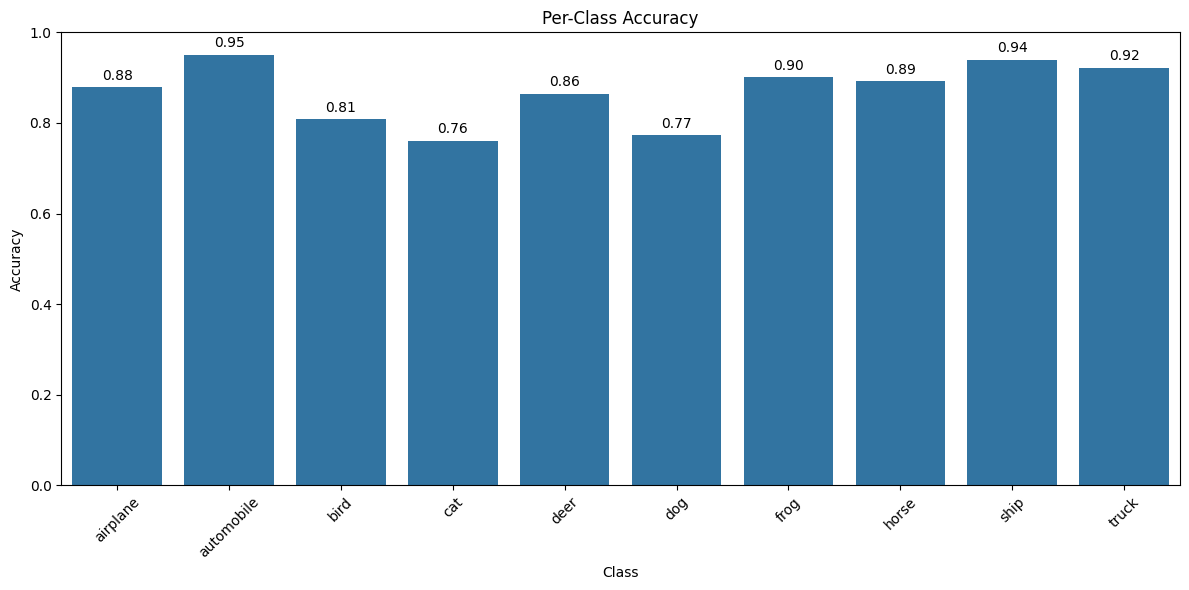

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracy = np.diag(cm) / np.sum(cm, axis=1)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_names, y=class_accuracy)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Add text labels above each bar with accuracy to 2 decimal places
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,  
        bar.get_height() + 0.01,          
        f'{class_accuracy[i]:.2f}',       
        ha='center',                      
        va='bottom',                      
        fontsize=10                       
    )

plt.tight_layout()
plt.show()